# Statistical Tests Intro
The purpose of this section is merely to introduce a couple of the most common statistical test.

There is no attempt to give a complete statistical background; there is no attempt to give any complete list of available tests.

The main purpose is to illustrate a typical usage of some of the most common python libraries when performing some more complex analysis.

The reader is invited to study the statistical theory before using any test in order to familiarize with names, objectives and common pitfalls.

## Bivariate Student's T test
We may want to verify if two sample datasets may be coming from the same distribution or different ones, i.e. they are not very different or they are different enough.

This test's hypothesis are the following:
- H0 (base hypothesis) both datasets are coming from a sampling of the same distribution
- H1 (alternative hypothesis) the datasets may have been sampled out of different distributions

In [127]:
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import ttest_ind

read daily temperatures measured in Rome from 1951 to 2009

This is the content:
|column| meaning|
|------|--------|
|SOUID| categorical: measurement source id
|DATE| calendar day in YYYYMMDD format
|TG| average temperature
|Q_TG| categorical: quality tag 9=invalid

In [128]:
roma = pd.read_csv("TG_SOUID100860.txt",skiprows=20)

This dataset column names include spaces, we need to remove them

In [129]:
roma.columns = list(map(str.strip,roma.columns))

In [130]:
roma.columns

Index(['SOUID', 'DATE', 'TG', 'Q_TG'], dtype='object')

In [131]:
roma.DATE = pd.to_datetime(roma.DATE,format="%Y%m%d")

In [132]:
roma["MONTH"] = roma.DATE.dt.month

In [133]:
roma["YEAR"] = roma.DATE.dt.year

In [134]:
roma_cleaned = roma.loc[roma.Q_TG != 9,:]

In [135]:
roma_giugno_1951 = roma_cleaned.loc[
    (roma_cleaned.YEAR == 1951) & (roma_cleaned.MONTH == 6),
    "TG"
]

In [136]:
roma_giugno_2009 = roma_cleaned.loc[
    (roma_cleaned.YEAR == 2009) & (roma_cleaned.MONTH == 6),
    "TG"
]

In [139]:
ttest_ind(roma_giugno_1951,roma_giugno_2009)

TtestResult(statistic=np.float64(-2.167425930725216), pvalue=np.float64(0.03432071944797424), df=np.float64(58.0))

<Axes: xlabel='TG', ylabel='Density'>

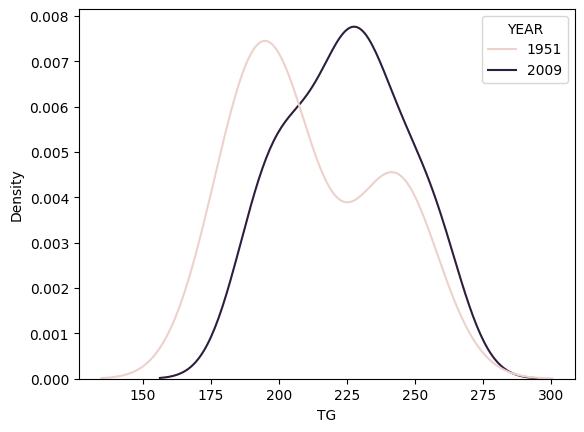

In [140]:
roma_giugno= roma_cleaned.loc[
    ((roma_cleaned.YEAR == 2009) |
     (roma_cleaned.YEAR == 1951)) & 
    (roma_cleaned.MONTH == 6)
]
sns.kdeplot(data=roma_giugno,x="TG",hue="YEAR")

## ANalyisis Of VAriance
[Analysis of Variance](https://en.wikipedia.org/wiki/Analysis_of_variance) is a family of methodologies that extend Student's T to more than two groups; their goal is to prove whether a factor makes a difference when it splits a set of measurements.

It can be used to show if a disease treatment is effective or not. The factor or categorical independend variable is the "input", while the health parameter is a continuous dependent variable or "output".

We are going to show the simplest use of it called `Fixed Mixture`

### (Optional) How it works
The main idea is to see how a grouping is or not relevant to explain the global variance

In order to understand this test we can derive a formula representing the contribution to the global variance given by each the variance within each subgroup and the variance between all subgroups

Let's start with the usual variance definition

\begin{equation}
var[X] := \frac{\sum_{x \in X}{(x - \bar{x})^2}}{n - 1}
\end{equation}

where $\bar{x} = E[X] = \frac{\sum_{x \in X}x}{card[X]}$

given a partition $X_i$ i.e. $\bigcup_{i \in G}{X_i} =  X$ and $n = card[X]$ ; $n_i = card[X_i]$ ; 

so $\bar{x_i} = E[X_i] = \frac{\sum_{x \in X_i}x}{n_i}$

breaking the sum into each subgroup and adding and removing $x_i$ inside the square we have

\begin{equation}
var[X] := \frac{\sum_{i \in G}{\sum_{x \in X_i}(x - \bar{x} + \bar{x_i} - \bar{x_i})^2}}{n - 1}
\end{equation}

developing the square

\begin{equation}
var[X] := \frac{\sum_{i \in G}{\sum_{x \in X_i}(x - \bar{x_i})^2 + (\bar{x_i} - \bar{x})^2 -2(x - \bar{x_i})(\bar{x_i} - \bar{x})}}{n - 1}
\end{equation}

we can bring the constant part outside of the sum

\begin{equation}
var[X] := \frac{\sum_{i \in G}{( n_i (\bar{x_i} - \bar{x})^2 + \sum_{x \in X_i}(x - \bar{x_i})^2 -2(\bar{x_i} - \bar{x})\sum_{x \in X_i}{(x - \bar{x_i})}})}{n - 1}
\end{equation}

by definition of $\bar{x_i}$ we have

\begin{equation}
\forall_{i \in G}\sum_{x \in X_i}{(x - \bar{x_i})} = 0
\end{equation}

so the last addend can be simplified; let's break the fraction

\begin{equation}
var[X] := \frac{\sum_{i \in G}{ n_i (\bar{x_i} - \bar{x})^2 }}{n - 1} + \frac{\sum_{i \in G}{\sum_{x \in X_i}(x - \bar{x_i})^2}}{n - 1}
\end{equation}

now we multiply and divide the second part by $n_i - 1$ in order to show how it may be seen as a variance

\begin{equation}
var[X] := \frac{\sum_{i \in G}{ n_i (\bar{x_i} - \bar{x})^2 }}{n - 1} + \sum_{i \in G}{\frac{(n_i - 1)}{n -1}\frac{\sum_{x \in X_i}(x - \bar{x_i})^2}{n_i - 1}}
\end{equation}

now we can show the variance of each subgroup

\begin{equation}
var[X] := \frac{\sum_{i \in G}{ n_i (\bar{x_i} - \bar{x})^2 }}{n - 1} + \sum_{i \in G}{\frac{(n_i - 1)}{n -1}var[X_i]}
\end{equation}

both addends are weighted; this is equivalent to

\begin{equation}
var[X] := var[E[X_i]] + E[var[X_i]]
\end{equation}


In [113]:
unemployment = pd.read_csv(
    "unemployment_it.csv",
    dtype={
        "Gender":"category",
        "Area":"category",
        "Age":"category",
    }
)
unemployment.columns

Index(['Age', 'Gender', 'Area', 'Frequency', 'Year', 'Rate'], dtype='object')

In [114]:
unemployment.Gender.unique()

['Male', 'Female']
Categories (2, object): ['Female', 'Male']

In [115]:
unemployment.Area.unique()

['North', 'North-west', 'North-east', 'Center', 'South']
Categories (5, object): ['Center', 'North', 'North-east', 'North-west', 'South']

In [116]:
import statsmodels.api as sm

In [117]:
from statsmodels.formula.api import ols

In [118]:
model = ols('Rate ~ Gender * Area * Year', data=unemployment).fit()

In [119]:
table = sm.stats.anova_lm(model, typ=2)

In [120]:
print(table)

                        sum_sq     df           F        PR(>F)
Gender             1285.245000    1.0   31.770447  6.601688e-08
Area              18194.797505    4.0  112.440984  7.299258e-48
Gender:Area          93.451500    4.0    0.577516  6.793006e-01
Year               1134.738195    1.0   28.050014  3.420439e-07
Gender:Year          20.187814    1.0    0.499030  4.808400e-01
Area:Year            15.967523    4.0    0.098677  9.827658e-01
Gender:Area:Year     40.068551    4.0    0.247617  9.108217e-01
Residual           7281.738917  180.0         NaN           NaN


In [123]:
import seaborn as sns

<Axes: xlabel='Rate', ylabel='Density'>

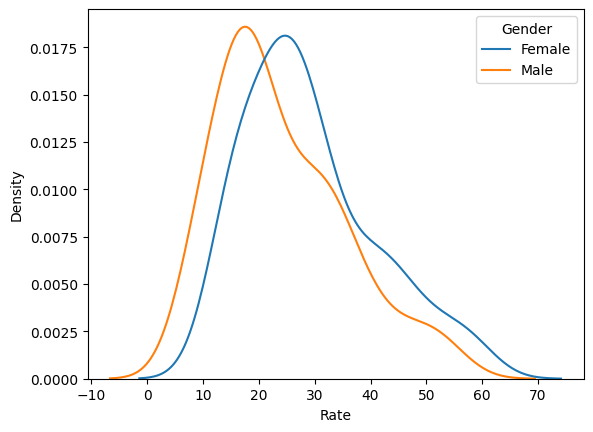

In [126]:
sns.kdeplot(data=unemployment,x="Rate",hue="Gender")

<Axes: xlabel='Rate', ylabel='Density'>

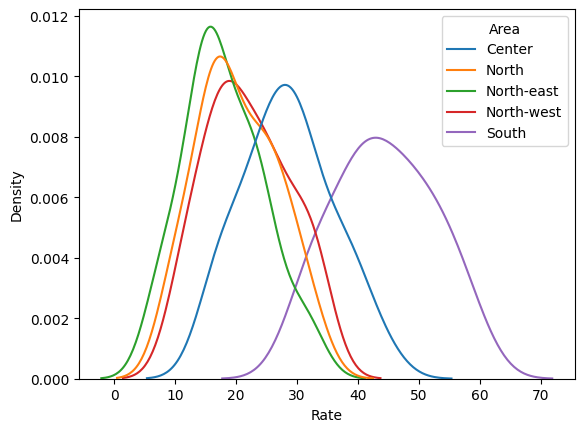

In [125]:
sns.kdeplot(data=unemployment,x="Rate",hue="Area")

Many examples are available on the internet, e.g. [this one](https://github.com/KenDaupsey/One-Way-Repeated-measures-ANOVA/blob/main/One_Way_Repeated_measures_ANOVA.ipynb)